In [1]:
import networkx as nx
import numpy as np
from math import *


In [2]:
morph = np.array([[0, 1], [0, 1]])

In [3]:
mapping={(i,j):morph[i][j] for i in range(0,morph.shape[0]) for j in range(0,morph.shape[1])}

In [4]:
mapping

{(0, 0): 0, (0, 1): 1, (1, 0): 0, (1, 1): 1}

In [5]:
m, n = morph.shape
G = nx.grid_2d_graph(m, n, periodic=False, create_using=None)

In [6]:

G.add_edge((0,0), (1, 1))
G.add_edge((0,1), (1, 0))

In [66]:
nx.set_node_attributes(G, mapping, name="color")

In [67]:
G.edges

EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 0), (1, 1)), ((0, 1), (1, 1)), ((0, 1), (1, 0)), ((1, 0), (1, 1))])

In [68]:
color = nx.get_node_attributes(G, "color")
color

{(0, 0): 0, (0, 1): 1, (1, 0): 0, (1, 1): 1}

In [69]:
def numberofPhaseVertices(G, phase):
    phases = nx.get_node_attributes(G, "color")
    phase_list = list(phases.values())
    return phase_list.count(phase)

In [70]:
c = numberofPhaseVertices(G, 0)
c

2

In [71]:
def node_phaseA(n, G):
    nodes = G.nodes
    return nodes[n]['color'] == 0

def node_phaseB(n, G):
    nodes = G.nodes
    return nodes[n]['color'] == 1

In [77]:
#Interface Edges
interface = [(n, u) for n, u in G.edges() 
    if (node_phaseA(n, G) and node_phaseB(u, G)) 
 or (node_phaseB(n, G) and node_phaseA(u, G)) 
]
len(interface)

4

In [56]:
#Sub-Graph
nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("color") == 0
)
subgraph = G.subgraph(nodes)
subgraph.nodes 

NodeView(((0, 0), (1, 0)))

In [59]:
#Connected Components
nx.number_connected_components(subgraph)

1

EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((1, 0), (1, 1))])

## Graph Grid Implementation


In [4]:
import networkx
import numpy as np
from itertools import product
import numpy.ma as ma
from toolz.curried import pipe, curry
from toolz.curried import map as fmap

89

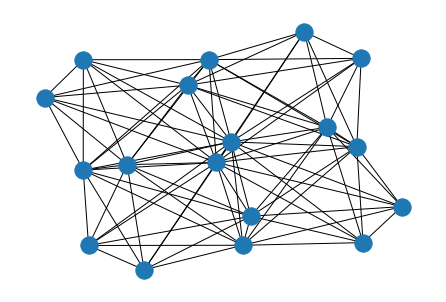

In [5]:
cond = lambda x: (x[:, 1] != -1) & (x[:, 0] != -1)

def merge_edges(neighbors, ids):
    return pipe(
        ids,
        lambda x: np.reshape(x.flatten(), (-1, 1, 1)),
        lambda x: np.repeat(x, neighbors.shape[1], axis=1),
        lambda x: np.concatenate((x, neighbors), axis=-1).reshape(-1, 2),
        lambda x: x[cond(x)],
    )

def index_vectors(nx, ny, nz):
    index2D = ([1, 0, 0], [1, 1, 0], [0, 1, 0], [-1, 1, 0])
    if ny == nz == 1:
        return ([1, 0, 0],)
    if nz == 1:
        return index2D
    else:
        return index2D + tuple([x, y, 1] for x in (1, 0, -1) for y in (1, 0, -1))

def make_ids_padded(ids):
    nx, ny, nz = ids.shape
    ids_padded = -np.ones((nx + 2, ny + 2, nz + 2), dtype=int)
    ids_padded[1:-1, 1:-1, 1:-1] = ids
    return ids_padded

@curry
def make_sub_ids(ids_padded, indices):
    nx, ny, nz = ids_padded.shape
    left, up, front = indices
    return ids_padded[1 + left:nx - 1 + left, 1 + up:ny - 1 + up, 1 + front:nz - 1 + front][..., None]

def make_neighbors(ids):
    nx, ny, nz = ids.shape
    ids_padded = make_ids_padded(ids)
    
    return pipe(
        index_vectors(nx, ny, nz),
        fmap(make_sub_ids(ids_padded)),
        list,
        lambda x: np.concatenate(x, axis=-1).reshape(nx * ny * nz, len(x), 1)
    )

def make_grid_edges(nx=1, ny=1, nz=1):
    ids = np.arange(nx * ny * nz).reshape(nx, ny, nz)
    return merge_edges(make_neighbors(ids), ids)

def make_grid_graph(shape):
    g = networkx.Graph()
    g.add_nodes_from(np.arange(np.prod(shape)))
    g.add_edges_from(make_grid_edges(*shape))
    return g

g = make_grid_graph((3, 3, 2))
networkx.draw(g)
g.number_of_edges()

In [7]:
def getNeighborhood1D(dim_x, dim_y):
    vertex_list = np.array(range(dim_x * dim_y))
    #neighborhood = np.zeros([vertex_list.shape[0], 8])
    
    #del_vertices = []
    del_vertices = list(range(0,dim_x * dim_y,dim_x))
    del_vertices += (list(range(dim_x - 1,dim_x * dim_y,dim_x)))
    
    del_vertices += list(range(1,dim_x))
    del_vertices += list(range(dim_x * (dim_y - 1) + 1 ,dim_x * dim_y ))
    del_vertices = list(set(del_vertices))
   
    
    vertex_list =[i for i in range(dim_x * dim_y) if i not in del_vertices]
    #print(vertex_list)
    neighborhood = np.array([[p-dim_x, (p-dim_x) + 1, p + 1, p + dim_x + 1, p + dim_x,
                             (p+dim_x) - 1, p - 1, (p - dim_x) - 1 ] for p in vertex_list ])
    #neighborhood[::dim_x, [5, 6, 7]] = -1
    #neighborhood[dim_x-1::dim_x, [1, 2, 3]] = -1
    #neighborhood[0, [0, 1, 5, 6, 7]] = -1
    #neighborhood[dim_x-1, [0, 1, 2, 3, 7]] = -1
    #neighborhood[dim_x * (dim_y -1), [3, 4, 5, 6, 7]] = -1
    #neighborhood[-1, [1, 2, 3, 4, 5]] = -1
    #neighborhood[0:dim_x, [0, 1, 7]] = -1
    #neighborhood[dim_x * (dim_y -1):, [3, 4, 5]] = -1

    return neighborhood, vertex_list

In [8]:

neighbors, vertex_list = getNeighborhood1D(5, 5)

vertex_list

[6, 7, 8, 11, 12, 13, 16, 17, 18]

In [9]:
neighbors

array([[ 1,  2,  7, 12, 11, 10,  5,  0],
       [ 2,  3,  8, 13, 12, 11,  6,  1],
       [ 3,  4,  9, 14, 13, 12,  7,  2],
       [ 6,  7, 12, 17, 16, 15, 10,  5],
       [ 7,  8, 13, 18, 17, 16, 11,  6],
       [ 8,  9, 14, 19, 18, 17, 12,  7],
       [11, 12, 17, 22, 21, 20, 15, 10],
       [12, 13, 18, 23, 22, 21, 16, 11],
       [13, 14, 19, 24, 23, 22, 17, 12]])

In [10]:
morph = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
morph_neighbors = morph[neighbors]
morph_neighbors[morph[vertex_list] == 0, :] = 0
potential_junctions = np.argwhere(np.sum(morph_neighbors, axis=1) >= 3)
potential_junctions = np.squeeze(potential_junctions)
c

array([3, 4])

In [12]:
morph_neighbors

array([[0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [13]:
# Neighbors of Potential Junctions
potential_junct_n = []
for i in potential_junctions:
    #print(list(np.where([morph_neighbors[i, :] == 1])[1]))
    #potential_junct_n.append(list(np.where(neighbors[morph_neighbors[i, :] == 1])[1]))
    k = neighbors[i][list(np.where([morph_neighbors[i, :] == 1])[1])]
    N = [i for i in range(len(vertex_list)) if vertex_list[i] in k]
    potential_junct_n.append(N)
potential_junct_n

[[0, 4, 6], [0, 3, 5, 6]]

In [14]:
potential_junct_n

[[0, 4, 6], [0, 3, 5, 6]]

In [15]:
# Potential Junction Neighbors of Potential Junctions
potential_junct_junct_n = []
for i in potential_junct_n:
    l = []
    [l.append(p) for p in i if p in potential_junctions]
    potential_junct_junct_n.append(l)
potential_junct_junct_n
junc_even_n = morph_neighbors[:,0] + morph_neighbors[:,2] + morph_neighbors[:,4] + morph_neighbors[:,6]   
potential_junct_junct_n

[[4], [3]]

In [16]:
potentipotential_junct_junct_nal_junct_junct_n

[[4], [3]]

In [18]:
del_junctions = []
for i in range(len(potential_junctions)):
    this_junc = potential_junct_junct_n[i]
    for j in this_junc:
        pos, = np.where(potential_junctions == j)
        #print(pos[0])
        #if len(this_junc) > len(potential_junct_junct_n[pos[0]]):
        if junc_even_n[i] > junc_even_n[pos[0]]:
            if pos not in del_junctions : del_junctions.append(pos[0])
        #elif len(this_junc) < len(potential_junct_junct_n[pos[0]]):
        elif junc_even_n[i] < junc_even_n[pos[0]]:
            if i not in del_junctions : del_junctions.append(i)
potential_junctions[del_junctions]      

array([4])

In [46]:
def check(l):
    n = 2
    subs = [l[i:i+n] for i in range(len(l)) if len(l[i:i+n]) == n]
    print(subs)
    return any([(sorted(sub) in range(min(l), max(l)+1)) for sub in subs])

In [47]:
def junc_elbows(morph_neighbors):
    pot_elbows = np.argwhere(np.sum(morph_neighbors, axis=1) == 3)
    for i in pot_elbows[0]:
        print(pot_elbows)
        #l = np.where(morph_neighbors[i])
        l = [0, 1, 2]
        print(l)
        print(check(l))

In [48]:
junc_elbows(morph_neighbors)

[[3]]
[0, 1, 2]
[[0, 1], [1, 2]]
False
